In [313]:
# import shap
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, chi2
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, KFold
import seaborn as sns

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score


# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import root_mean_squared_log_error

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# tunning hyperparamters model
import optuna

import warnings
warnings.filterwarnings('ignore')

In [314]:
pd.set_option('display.max_rows', 100)      # показывать до 50 строк
pd.set_option('display.max_columns', 50)    # показывать до 50 столбцов
pd.set_option('display.width', None)        # автоматическая ширина вывода (без переносов)
# pd.set_option('display.max_colwidth', None) # полная ширина содержимого ячейки

In [315]:
dir_path = r"data/"
train = pd.read_csv(dir_path + 'train.csv')

test = pd.read_csv(dir_path + 'test.csv')

sample_submission = pd.read_csv(dir_path + 'sample_submission.csv')

In [316]:
train['is_train'] = 1
test['is_train'] = 0
test['SalePrice'] = np.nan
train_ids = train['Id']
test_ids = test['Id']
train = train.drop('Id', axis=1)
test = test.drop('Id', axis=1)

union_df = pd.concat([train, test], ignore_index=True)

In [317]:
union_df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  ...  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace  ...   
1          1976     Gable  CompShg     MetalSd     MetalSd        NaN  ...   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace  ...   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN  ...   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace  ...   

   FireplaceQu GarageType GarageYrBlt GarageFinish GarageCars GarageArea  \
0          NaN     Attchd      2003.0          RFn        2.0      548.0   
1           TA     Attchd      1976.0          RFn        2.0      460.0   
2           TA     Attchd      2001.0          RFn        2.0      608.0   
3           Gd     Detchd      1998.0          Unf        3.0      642.0   
4           TA     Attchd      2000.0          RFn        3.0      836.0   

  GarageQual GarageCond  PavedDrive WoodDeckSF  OpenPorchSF  EnclosedPorch  \
0         TA         TA           Y          0           61              0   
1         TA         TA           Y        298            0              0   
2         TA         TA           Y          0           42              0   
3         TA         TA           Y          0           35            272   
4         TA         TA           Y        192           84              0   

   3SsnPorch ScreenPorch PoolArea PoolQC Fence  MiscFeature  MiscVal  MoSold  \
0          0           0        0    NaN   NaN          NaN        0       2   
1          0           0        0    NaN   NaN          NaN        0       5   
2          0           0        0    NaN   NaN          NaN        0       9   
3          0           0        0    NaN   NaN          NaN        0       2   
4          0           0        0    NaN   NaN          NaN        0      12   

   YrSold  SaleType  SaleCondition  SalePrice  is_train  
0    2008        WD         Normal   208500.0         1  
1    2007        WD         Normal   181500.0         1  
2    2008        WD         Normal   223500.0         1  
3    2006        WD        Abnorml   140000.0         1  
4    2008        WD         Normal   250000.0         1  

[5 rows x 81 columns]

In [318]:
train.isna().mean().sort_values(ascending=False)

PoolQC           0.995205
MiscFeature      0.963014
Alley            0.937671
Fence            0.807534
MasVnrType       0.597260
FireplaceQu      0.472603
LotFrontage      0.177397
GarageYrBlt      0.055479
GarageFinish     0.055479
GarageQual       0.055479
GarageCond       0.055479
GarageType       0.055479
BsmtFinType2     0.026027
BsmtExposure     0.026027
BsmtFinType1     0.025342
BsmtQual         0.025342
BsmtCond         0.025342
MasVnrArea       0.005479
Electrical       0.000685
BldgType         0.000000
HouseStyle       0.000000
Condition1       0.000000
Neighborhood     0.000000
LandSlope        0.000000
Condition2       0.000000
Utilities        0.000000
LandContour      0.000000
LotShape         0.000000
Street           0.000000
MSZoning         0.000000
LotArea          0.000000
MSSubClass       0.000000
LotConfig        0.000000
OverallQual      0.000000
ExterCond        0.000000
BsmtFinSF2       0.000000
ExterQual        0.000000
TotalBsmtSF      0.000000
Heating     

In [319]:
union_df.isna().mean().sort_values(ascending=False)

PoolQC           0.996574
MiscFeature      0.964029
Alley            0.932169
Fence            0.804385
MasVnrType       0.605002
SalePrice        0.499829
FireplaceQu      0.486468
LotFrontage      0.166495
GarageCond       0.054471
GarageFinish     0.054471
GarageYrBlt      0.054471
GarageQual       0.054471
GarageType       0.053786
BsmtExposure     0.028092
BsmtCond         0.028092
BsmtQual         0.027749
BsmtFinType2     0.027407
BsmtFinType1     0.027064
MasVnrArea       0.007879
MSZoning         0.001370
Functional       0.000685
BsmtFullBath     0.000685
Utilities        0.000685
BsmtHalfBath     0.000685
SaleType         0.000343
BsmtFinSF1       0.000343
BsmtUnfSF        0.000343
Electrical       0.000343
TotalBsmtSF      0.000343
Exterior2nd      0.000343
KitchenQual      0.000343
GarageCars       0.000343
GarageArea       0.000343
Exterior1st      0.000343
BsmtFinSF2       0.000343
OverallQual      0.000000
Condition2       0.000000
Condition1       0.000000
HouseStyle  

строим гистограмму распределения цены жилья

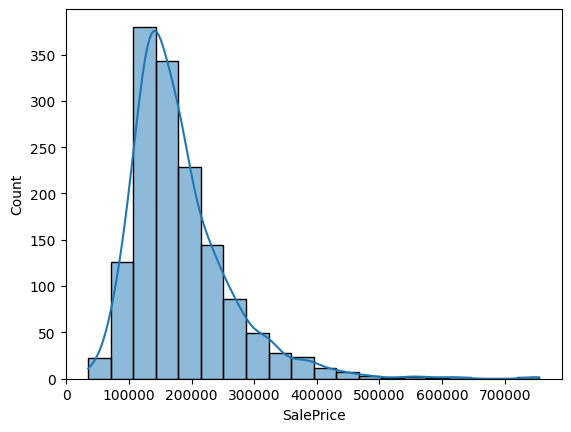

In [320]:
sns.histplot(union_df['SalePrice'], bins=20, kde=True)
plt.show()

скошено вправо. есть выбросы. сделаем нормирование цены `SalePrice`. используем log1p

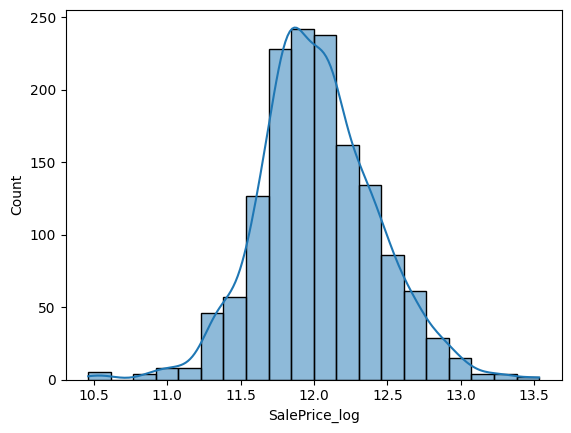

In [321]:
union_df['SalePrice_log'] = np.log1p(union_df['SalePrice'])
# scaler = RobustScaler()
# union_df['SalePrice_log_scaled'] = scaler.fit_transform(union_df[['SalePrice_log']])
sns.histplot(union_df['SalePrice_log'], bins=20, kde=True)
plt.show()

после нормирования значения стали приближены к нормальным

In [322]:
union_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   str    
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   str    
 5   Alley          198 non-null    str    
 6   LotShape       2919 non-null   str    
 7   LandContour    2919 non-null   str    
 8   Utilities      2917 non-null   str    
 9   LotConfig      2919 non-null   str    
 10  LandSlope      2919 non-null   str    
 11  Neighborhood   2919 non-null   str    
 12  Condition1     2919 non-null   str    
 13  Condition2     2919 non-null   str    
 14  BldgType       2919 non-null   str    
 15  HouseStyle     2919 non-null   str    
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt      2919

In [323]:
num_cols = union_df.select_dtypes(include='number').columns.tolist()
len(num_cols)

39

In [324]:
obj_cols = union_df.select_dtypes(include='object').columns.tolist()
len(obj_cols)

43

Графики числовых переменных

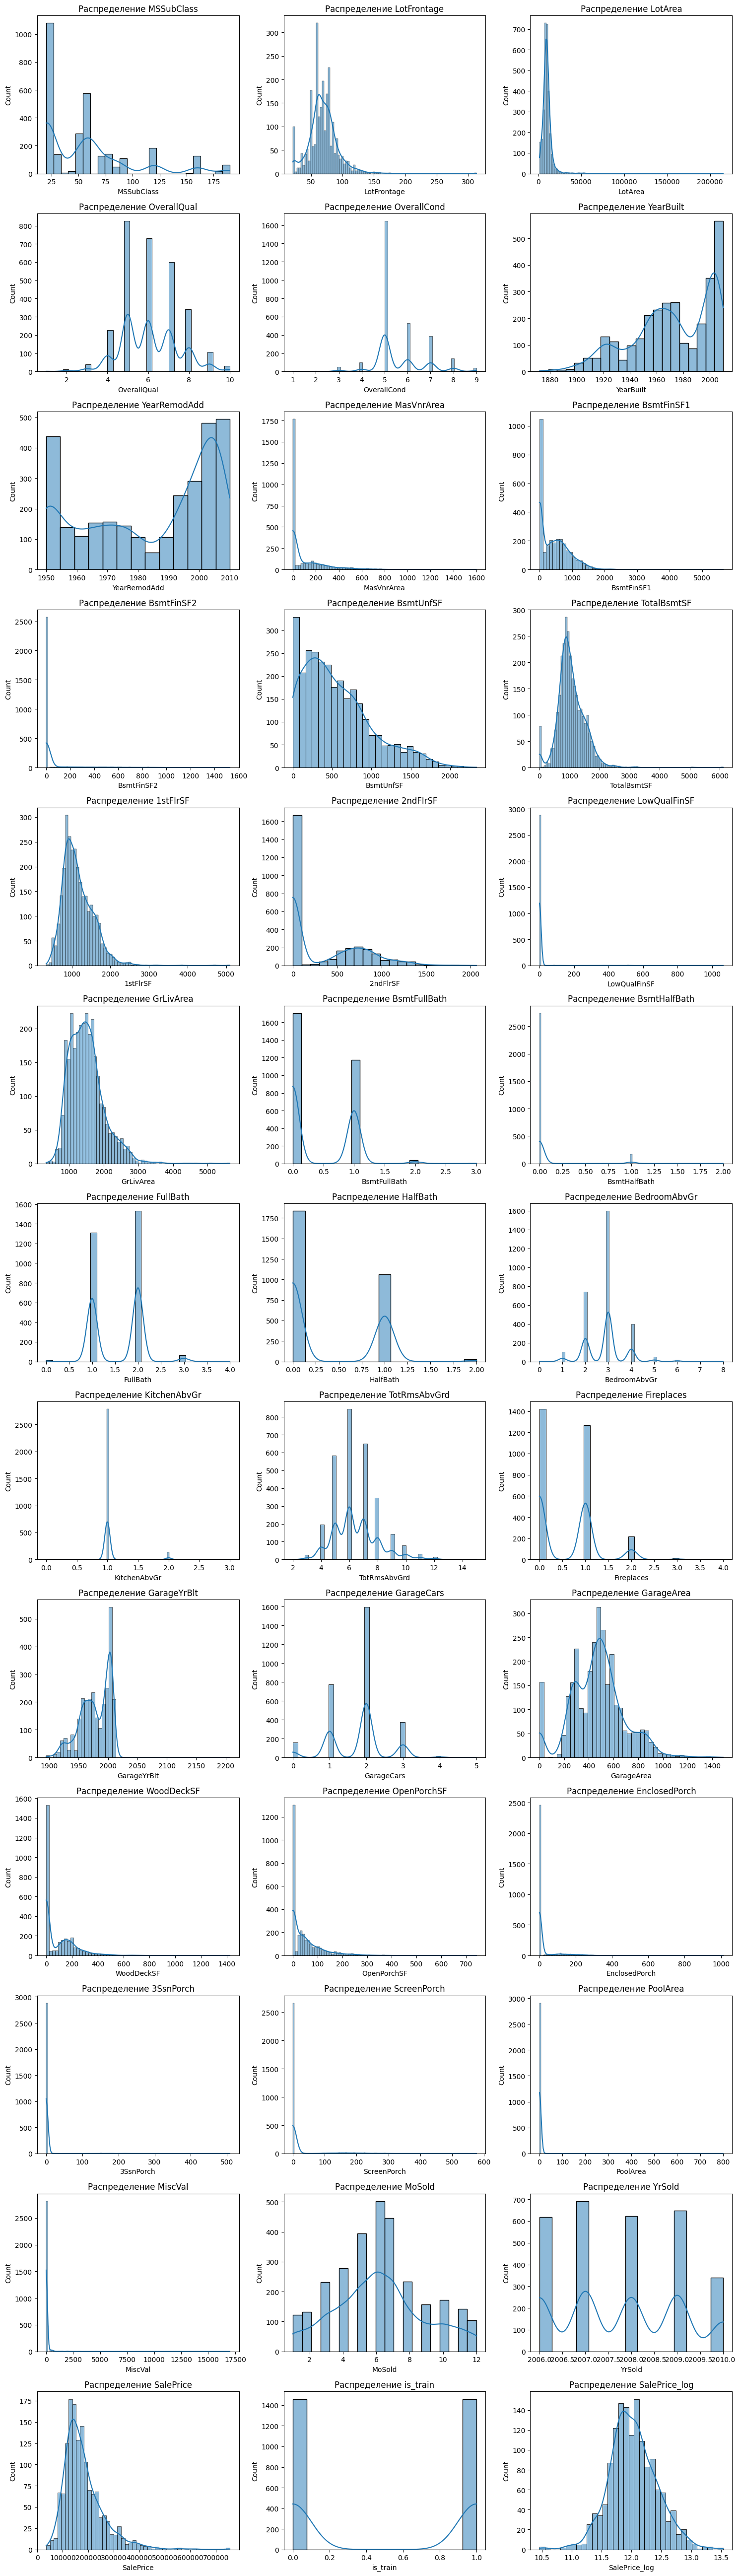

In [325]:
cols = union_df.select_dtypes(include='number').columns
n_cols = 3
n_rows = (len(cols) - 1) // n_cols + 1

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() # Превращаем матрицу осей в плоский список

for i, col in enumerate(cols):
    sns.histplot(union_df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Распределение {col}')

# Удаляем пустые графики, если колонок меньше, чем ячеек в сетке
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Графики категориальных переменных

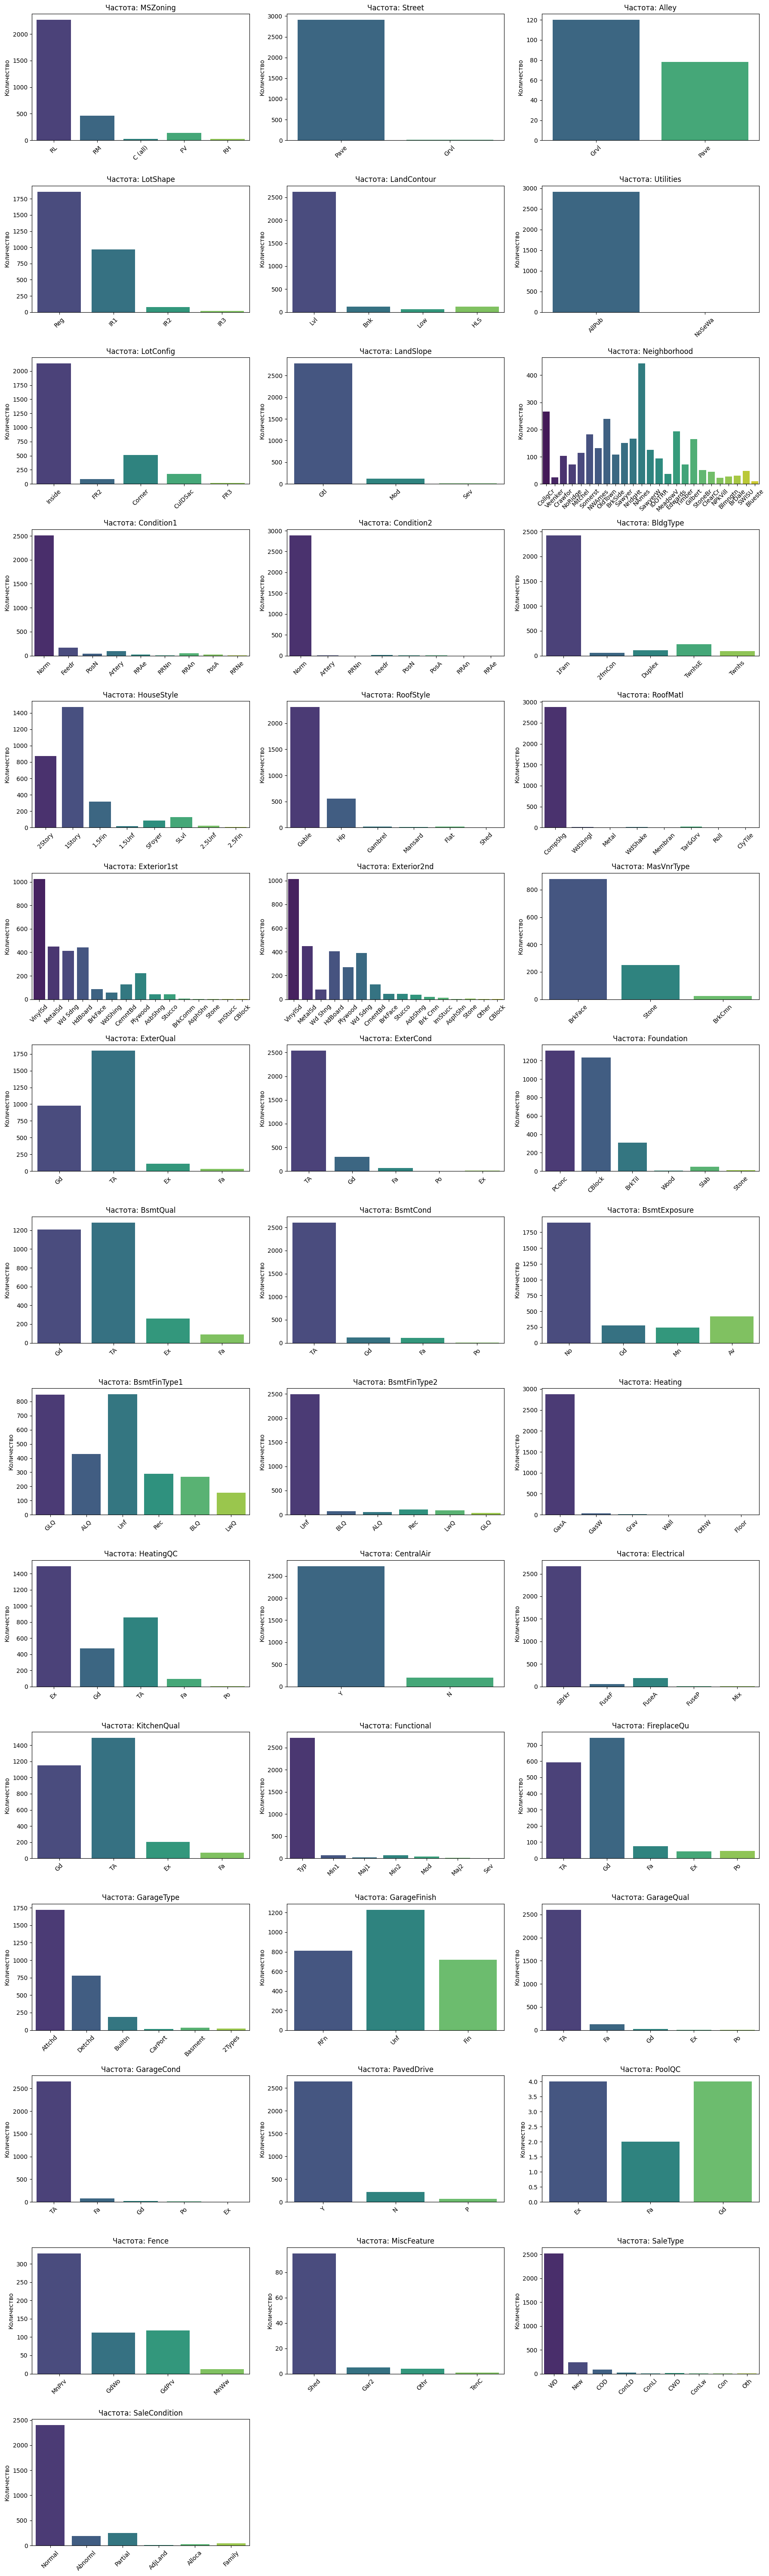

In [326]:
cols = union_df.select_dtypes(include='object').columns
n_cols = 3
n_rows = (len(cols) - 1) // n_cols + 1

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(cols):
    # Используем countplot для категориальных данных
    sns.countplot(data=union_df, x=col, ax=axes[i], palette='viridis', hue=col, legend=False)
    
    axes[i].set_title(f'Частота: {col}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45) # Поворачиваем текст, чтобы не накладывался
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Количество')

# Удаляем пустые ячейки
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [327]:
correlations = union_df.corr(numeric_only=True)['SalePrice'].sort_values(key=lambda x: abs(x), ascending=False)
print(correlations)

SalePrice        1.000000
SalePrice_log    0.948374
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
is_train    

HEATMAP Числовых переменных

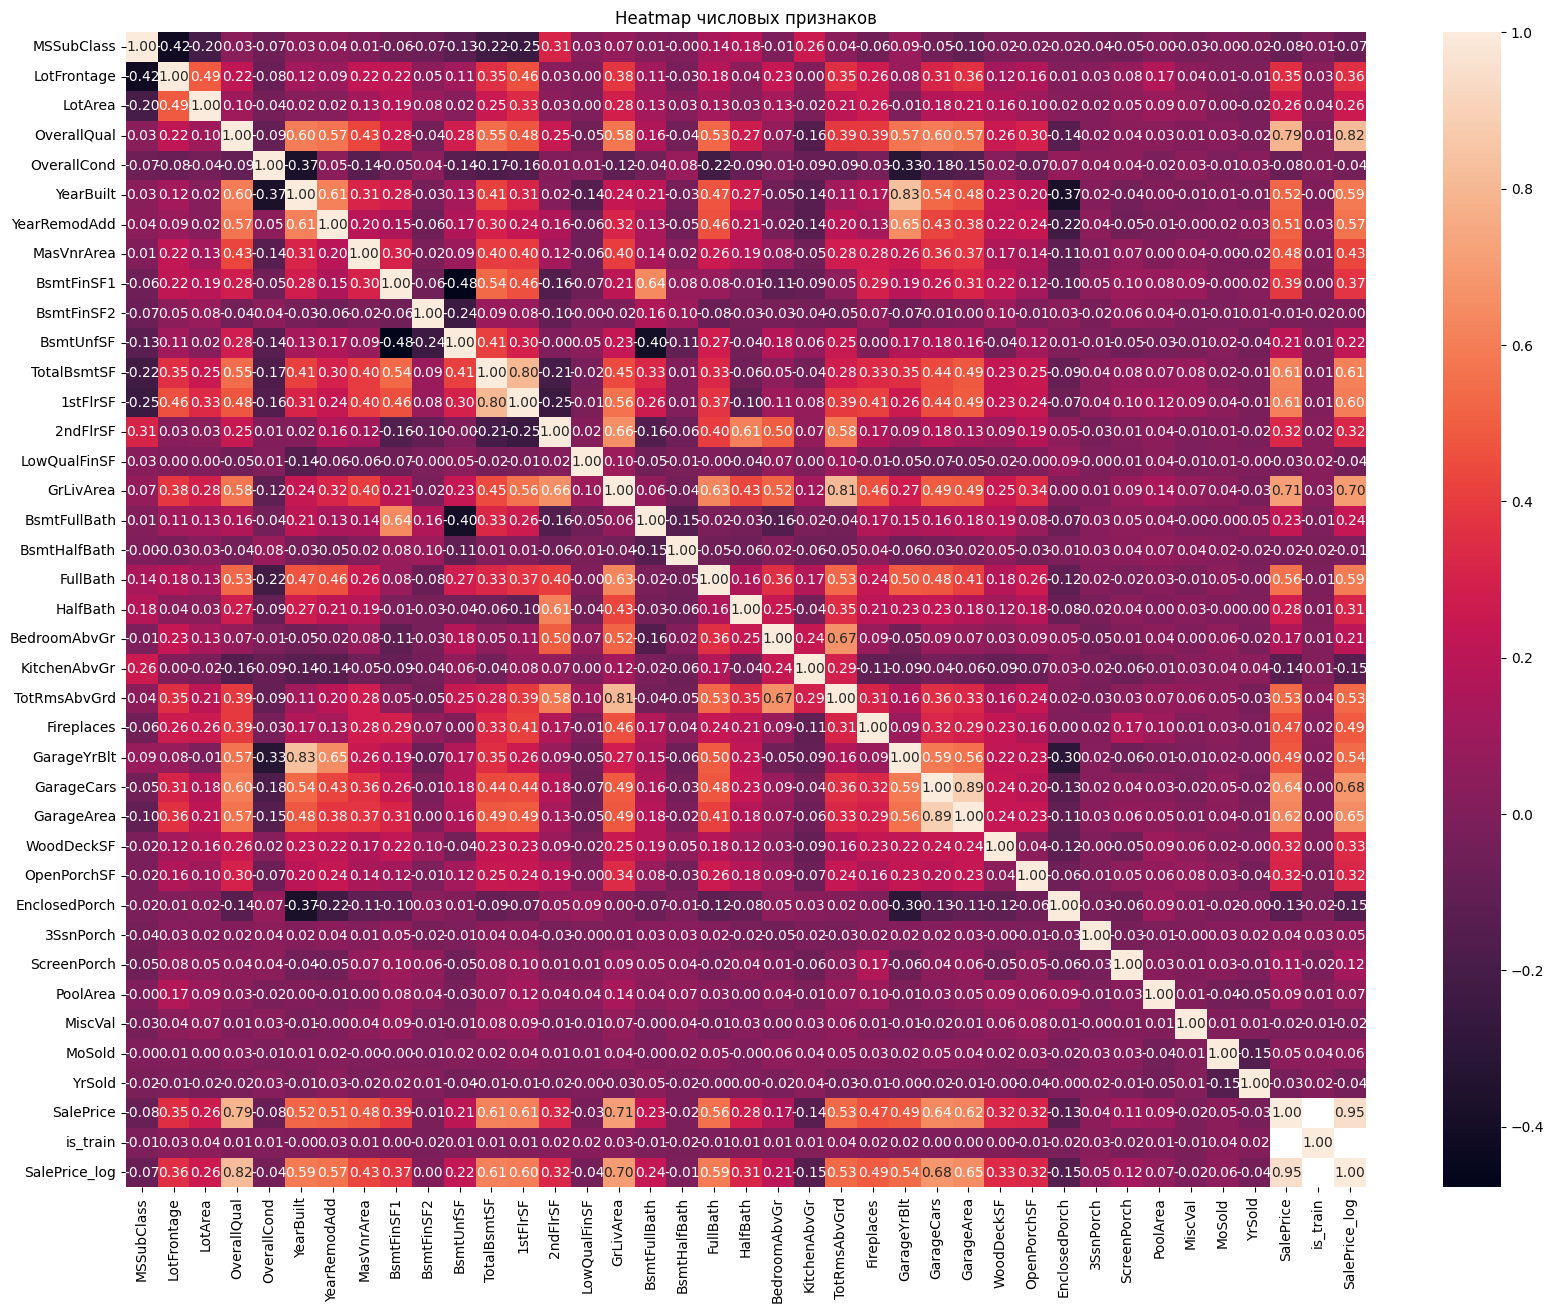

In [328]:
plt.figure(figsize=(20,15))
correlations = union_df.corr(numeric_only=True)
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Heatmap числовых признаков')
plt.show()

In [329]:
# # много пропусков
# # col_drop_nan = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']

# # низкая связь с таргетом
# col_drop_low = ['MiscVal', 'BsmtHalfBath', 'BsmtFinSF2']

# # дубли данных, схожие данные, избыточность
# # col_drop_duble = ['GarageQual', 'GarageFinish', '1stFlrSF', '2ndFlrSF', 'Street', 'Utilities'] 
# col_drop_duble = ['GarageQual', 'Street', 'Utilities']

# # корреляция данных
# col_drop_corr = ['GarageYrBlt']

# # не влияет на цену, так как предсказываем цену
# # col_drop_last = ['YrSold', 'MoSold', 'SaleType', 'SaleCondition']

# col_drop_last = ['YrSold', 'MoSold', 'SaleType']

# col_drop_total = col_drop_low + col_drop_duble + col_drop_corr + col_drop_last

# col_drop_total

# # 'GarageFinish', '1stFlrSF', '2ndFlrSF', 'SaleCondition'
# union_df = union_df.drop(col_drop_total, axis=1)

In [330]:
union_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   str    
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   str    
 5   Alley          198 non-null    str    
 6   LotShape       2919 non-null   str    
 7   LandContour    2919 non-null   str    
 8   Utilities      2917 non-null   str    
 9   LotConfig      2919 non-null   str    
 10  LandSlope      2919 non-null   str    
 11  Neighborhood   2919 non-null   str    
 12  Condition1     2919 non-null   str    
 13  Condition2     2919 non-null   str    
 14  BldgType       2919 non-null   str    
 15  HouseStyle     2919 non-null   str    
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt      2919

In [331]:
# проверям пропуски
pd.DataFrame(data={'NaN_count': union_df.isna().mean(), 'data_type':union_df.dtypes}).sort_values(by='NaN_count', ascending=False)

NaN_count data_type
PoolQC          0.996574       str
MiscFeature     0.964029       str
Alley           0.932169       str
Fence           0.804385       str
MasVnrType      0.605002       str
SalePrice_log   0.499829   float64
SalePrice       0.499829   float64
FireplaceQu     0.486468       str
LotFrontage     0.166495   float64
GarageFinish    0.054471       str
GarageQual      0.054471       str
GarageYrBlt     0.054471   float64
GarageCond      0.054471       str
GarageType      0.053786       str
BsmtExposure    0.028092       str
BsmtCond        0.028092       str
BsmtQual        0.027749       str
BsmtFinType2    0.027407       str
BsmtFinType1    0.027064       str
MasVnrArea      0.007879   float64
MSZoning        0.001370       str
BsmtFullBath    0.000685   float64
Functional      0.000685       str
BsmtHalfBath    0.000685   float64
Utilities       0.000685       str
SaleType        0.000343       str
KitchenQual     0.000343       str
BsmtFinSF1      0.000343   float64
TotalBsmtSF     0.000343   float64
Electrical      0.000343       str
BsmtFinSF2      0.000343   float64
BsmtUnfSF       0.000343   float64
GarageCars      0.000343   float64
GarageArea      0.000343   float64
Exterior1st     0.000343       str
Exterior2nd     0.000343       str
OverallCond     0.000000     int64
OverallQual     0.000000     int64
Condition2      0.000000       str
Condition1      0.000000       str
HouseStyle      0.000000       str
BldgType        0.000000       str
LotConfig       0.000000       str
LandContour     0.000000       str
LotShape        0.000000       str
Street          0.000000       str
LotArea         0.000000     int64
MSSubClass      0.000000     int64
Neighborhood    0.000000       str
LandSlope       0.000000       str
HalfBath        0.000000     int64
FullBath        0.000000     int64
LowQualFinSF    0.000000     int64
GrLivArea       0.000000     int64
2ndFlrSF        0.000000     int64
1stFlrSF        0.000000     int64
HeatingQC       0.000000       str
CentralAir      0.000000       str
Heating         0.000000       str
YearRemodAdd    0.000000     int64
RoofStyle       0.000000       str
RoofMatl        0.000000       str
YearBuilt       0.000000     int64
Foundation      0.000000       str
ExterQual       0.000000       str
ExterCond       0.000000       str
WoodDeckSF      0.000000     int64
PavedDrive      0.000000       str
BedroomAbvGr    0.000000     int64
Fireplaces      0.000000     int64
TotRmsAbvGrd    0.000000     int64
KitchenAbvGr    0.000000     int64
ScreenPorch     0.000000     int64
OpenPorchSF     0.000000     int64
PoolArea        0.000000     int64
EnclosedPorch   0.000000     int64
3SsnPorch       0.000000     int64
MiscVal         0.000000     int64
YrSold          0.000000     int64
MoSold          0.000000     int64
SaleCondition   0.000000       str
is_train        0.000000     int64


GarageCond	0.054471	str             NA	No Garage       Состояние гаража
GarageType	0.053786	str             NA  No Garage          Тип гаража
BsmtFinType2	0.027407	str         NA	No Basement     Тип отделки остальной площади подвала (если есть)
BsmtFullBath	0.000685	float64     BsmtFullBath: Basement full bathrooms                                                       median
Functional	0.000685	str             Home functionality (Assume typical unless deductions are warranted)                         mode
GarageCars	0.000343	float64         Size of garage in car capacity зависимость от площади
BsmtUnfSF	0.000343	float64         Unfinished square feet of basement area
KitchenQual	0.000343	str             Kitchen quality Ex	Excellent, Gd	Good, TA	Typical/Average, Fa	Fair, Po	Poor        mode
GarageArea	0.000343	float64         GarageArea: Size of garage in square feet                                                   зависимость от количества машин
Electrical	0.000343	str             Electrical: Electrical system                                                               mode
TotalBsmtSF	0.000343	float64         TotalBsmtSF: Total square feet of basement area       площадь                                      median посмотреть на группировку по площади дома

заполняем пропуски NA для строковых переменных в которых это показывает отсутствие на строку 'None'

числовые поля BsmtFullBath, BsmtUnfSF, GarageCars, GarageArea заполнить 0. Если бы были то обязательно заполнили бы, так как это влияет на цену

['Functional', 'Electrical', 'KitchenQual'] - заполняем модой, так как это случайные пропуски электричество в доме должно быть, как и кухня как и Functional общее состояние дома

In [332]:
# cols_fillna_0 = ['MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'GarageYrBlt']
# cols_fillna_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
# cols_fillna_mode = ['MSZoning', 'Functional', 'Utilities', 'SaleType', 'KitchenQual', 'Electrical', 'Exterior1st', 'Exterior2nd']

# union_df[cols_fillna_0] = union_df[cols_fillna_0].fillna(0)
# union_df[cols_fillna_none] = union_df[cols_fillna_none].fillna('None')
# for col in cols_fillna_mode:
#     union_df[col] = union_df[col].fillna(union_df[col].mode()[0])

# union_df['LotFrontage'] = union_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# union_df['LotFrontage'] = union_df['LotFrontage'].fillna(union_df['LotFrontage'].median())

In [333]:
# Переменные для обработки пропусков

cols_fillna_0 = ['MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'GarageYrBlt']

cols_fillna_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']

cols_fillna_mode = ['MSZoning', 'Functional', 'Utilities', 'SaleType', 'KitchenQual', 'Electrical', 'Exterior1st', 'Exterior2nd']

In [334]:
class LotFrontageMedImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.medians_ = {}
        self.overall_median_ = None
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist()
        # Группируем и сохраняем медианы
        self.medians_ = X.groupby('Neighborhood')['LotFrontage'].median()
        self.overall_median_ = X['LotFrontage'].median()
        return self

    def transform(self, X):
        X = X.copy()
        # Заполняем через сохраненные медианы районов
        X['LotFrontage'] = X['LotFrontage'].fillna(X['Neighborhood'].map(self.medians_))
        X['LotFrontage'] = X['LotFrontage'].fillna(self.overall_median_)
        return X

    def get_feature_names_out(self, input_features=None):
        return self.feature_names_in_

# 2. Собираем общий ColumnTransformer
imputer = ColumnTransformer(
    transformers=[
        # Наш кастомный импьютер (ему нужны и LotFrontage, и Neighborhood)
        ('lot_frontage_imp', LotFrontageMedImputer(), ['LotFrontage', 'Neighborhood']),
        
        # Заполнение нулями
        ('num_zero', SimpleImputer(strategy='constant', fill_value=0), cols_fillna_0),
        
        # Заполнение 'None'
        ('cat_none', SimpleImputer(strategy='constant', fill_value='None'), cols_fillna_none),
        
        # Заполнение модой
        ('cat_mode', SimpleImputer(strategy='most_frequent'), cols_fillna_mode)
    ],
    verbose_feature_names_out = False,
    remainder='passthrough'
).set_output(transform='pandas')

In [335]:
df = imputer.fit_transform(union_df)

In [336]:
# # проверям пропуски
pd.DataFrame(data={'NaN_count': df.isna().mean(), 'data_type':df.dtypes}).sort_values(by='NaN_count', ascending=False)

NaN_count data_type
SalePrice_log   0.499829   float64
SalePrice       0.499829   float64
MasVnrArea      0.000000   float64
BsmtFullBath    0.000000   float64
BsmtHalfBath    0.000000   float64
BsmtFinSF1      0.000000   float64
BsmtFinSF2      0.000000   float64
BsmtUnfSF       0.000000   float64
TotalBsmtSF     0.000000   float64
GarageCars      0.000000   float64
GarageArea      0.000000   float64
GarageYrBlt     0.000000   float64
PoolQC          0.000000       str
MiscFeature     0.000000       str
Alley           0.000000       str
Fence           0.000000       str
LotFrontage     0.000000   float64
Neighborhood    0.000000       str
GarageType      0.000000       str
FireplaceQu     0.000000       str
GarageFinish    0.000000       str
GarageQual      0.000000       str
BsmtCond        0.000000       str
BsmtExposure    0.000000       str
GarageCond      0.000000       str
BsmtQual        0.000000       str
MasVnrType      0.000000       str
MSZoning        0.000000       str
Functional      0.000000       str
Utilities       0.000000       str
SaleType        0.000000       str
KitchenQual     0.000000       str
BsmtFinType1    0.000000       str
BsmtFinType2    0.000000       str
Exterior2nd     0.000000       str
MSSubClass      0.000000     int64
LotArea         0.000000     int64
Street          0.000000       str
LotShape        0.000000       str
LandContour     0.000000       str
LotConfig       0.000000       str
LandSlope       0.000000       str
Condition1      0.000000       str
Condition2      0.000000       str
BldgType        0.000000       str
HouseStyle      0.000000       str
OverallQual     0.000000     int64
OverallCond     0.000000     int64
Electrical      0.000000       str
Exterior1st     0.000000       str
YearRemodAdd    0.000000     int64
YearBuilt       0.000000     int64
RoofStyle       0.000000       str
RoofMatl        0.000000       str
Foundation      0.000000       str
Heating         0.000000       str
ExterQual       0.000000       str
ExterCond       0.000000       str
1stFlrSF        0.000000     int64
2ndFlrSF        0.000000     int64
LowQualFinSF    0.000000     int64
GrLivArea       0.000000     int64
FullBath        0.000000     int64
HalfBath        0.000000     int64
HeatingQC       0.000000       str
CentralAir      0.000000       str
KitchenAbvGr    0.000000     int64
BedroomAbvGr    0.000000     int64
TotRmsAbvGrd    0.000000     int64
Fireplaces      0.000000     int64
OpenPorchSF     0.000000     int64
EnclosedPorch   0.000000     int64
PavedDrive      0.000000       str
WoodDeckSF      0.000000     int64
ScreenPorch     0.000000     int64
3SsnPorch       0.000000     int64
PoolArea        0.000000     int64
MiscVal         0.000000     int64
YrSold          0.000000     int64
MoSold          0.000000     int64
SaleCondition   0.000000       str
is_train        0.000000     int64

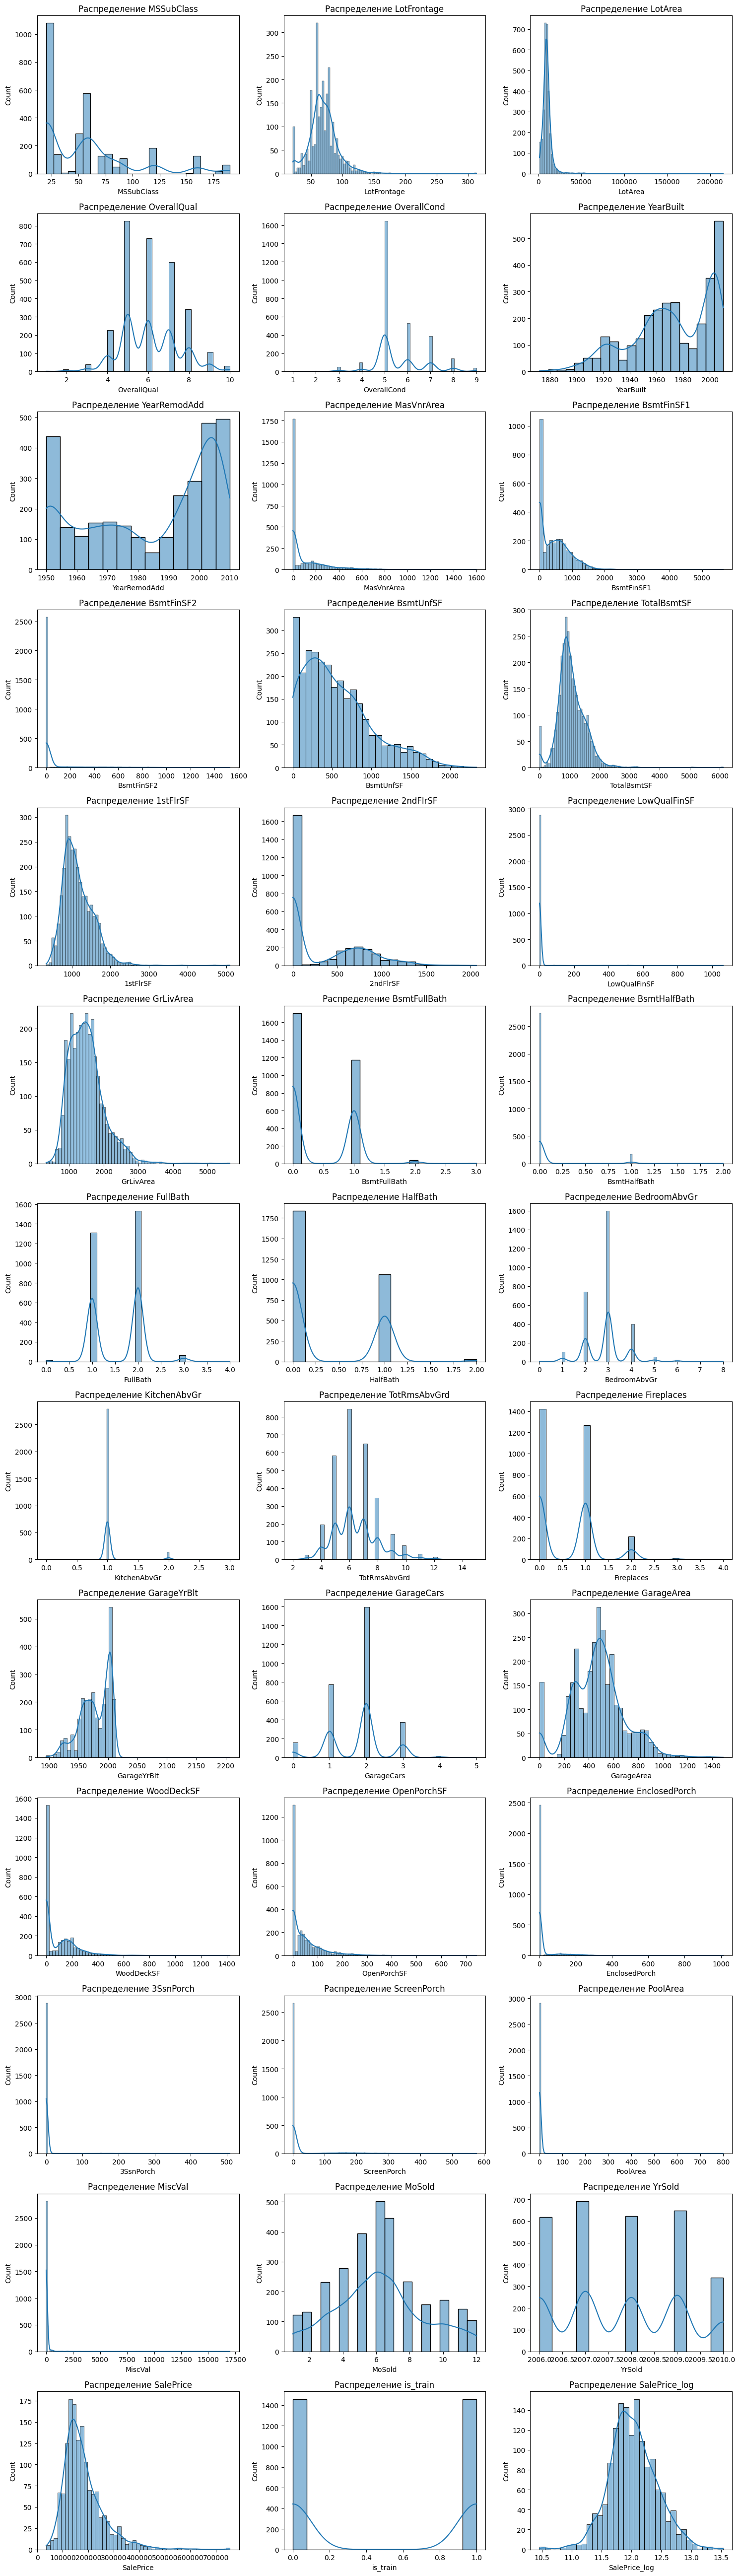

In [337]:
cols = union_df.select_dtypes(include='number').columns
n_cols = 3
n_rows = (len(cols) - 1) // n_cols + 1

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() # Превращаем матрицу осей в плоский список

for i, col in enumerate(cols):
    sns.histplot(union_df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Распределение {col}')

# Удаляем пустые графики, если колонок меньше, чем ячеек в сетке
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

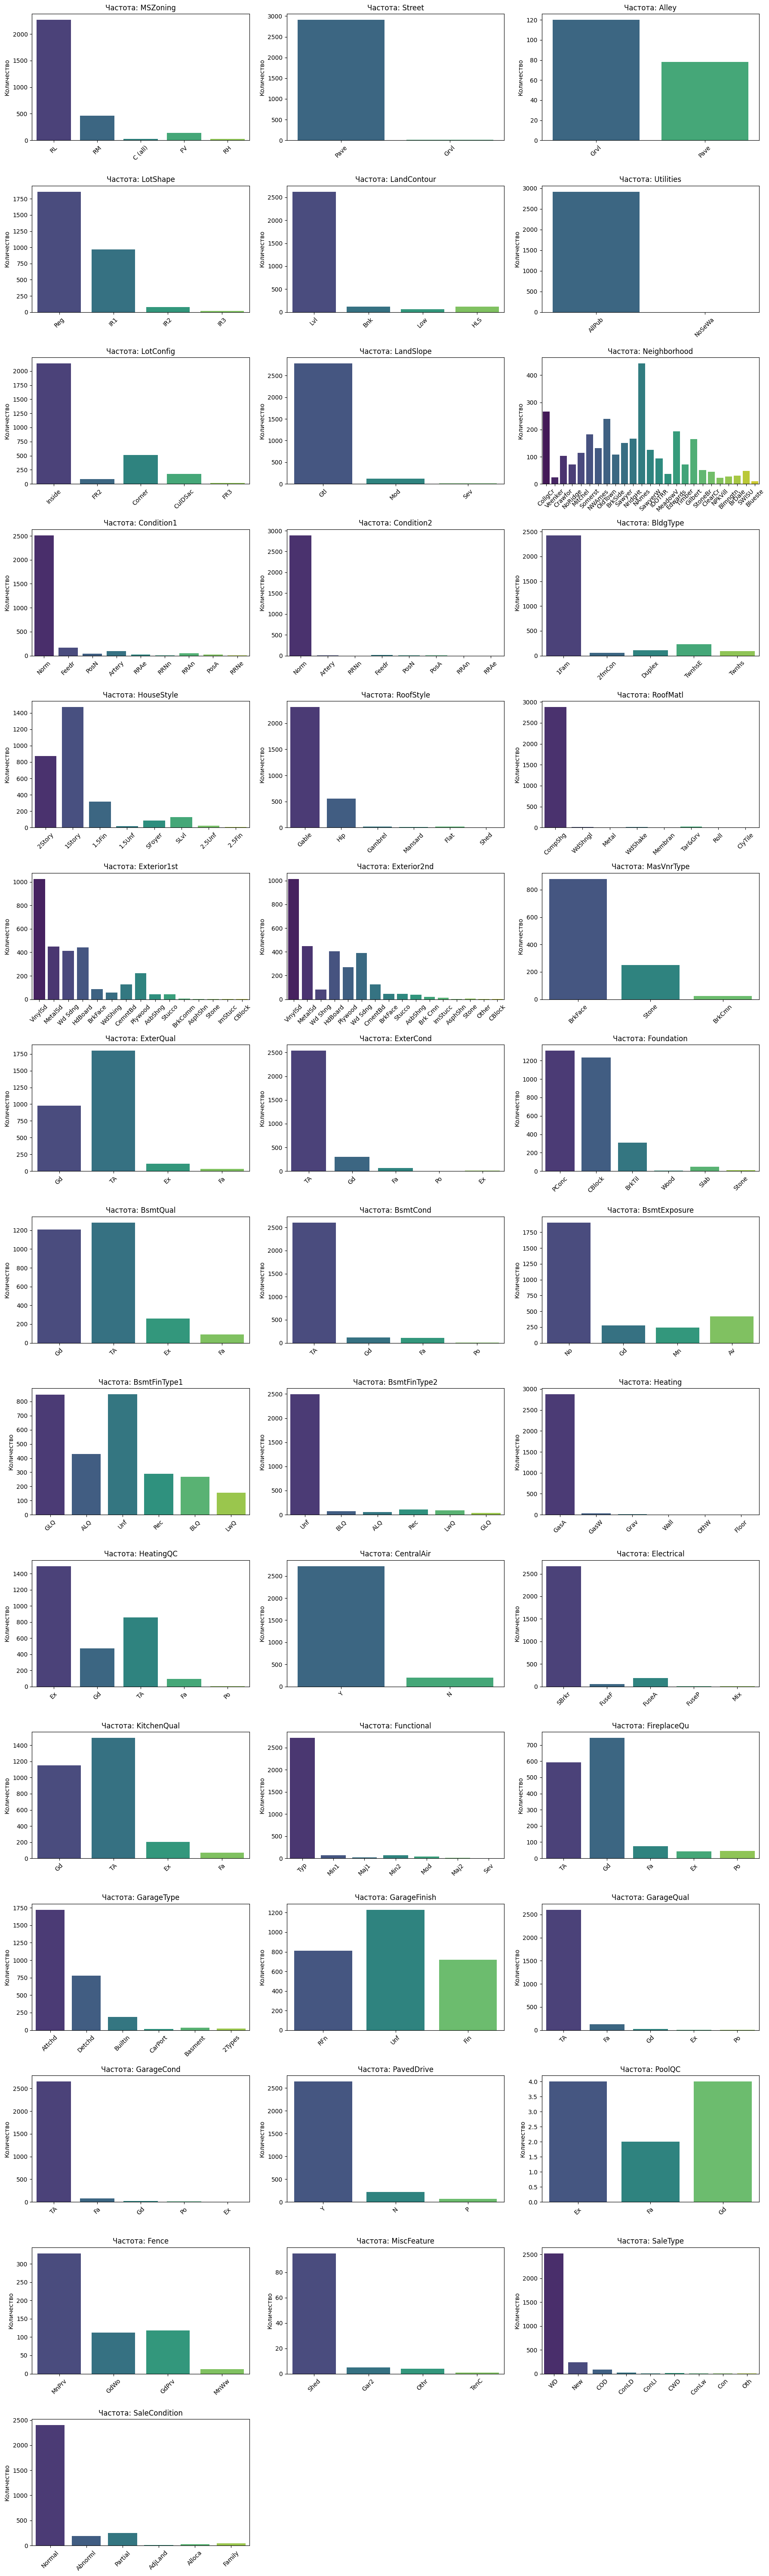

In [338]:
cols = union_df.select_dtypes(include='object').columns
n_cols = 3
n_rows = (len(cols) - 1) // n_cols + 1

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(cols):
    # Используем countplot для категориальных данных
    sns.countplot(data=union_df, x=col, ax=axes[i], palette='viridis', hue=col, legend=False)
    
    axes[i].set_title(f'Частота: {col}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45) # Поворачиваем текст, чтобы не накладывался
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Количество')

# Удаляем пустые ячейки
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [339]:
union_df = imputer.fit_transform(union_df)

Разделяем выборки

In [340]:
X_train_clean = union_df[union_df['is_train']==1].drop(['SalePrice', 'is_train', 'SalePrice_log'], axis=1).copy()
y_train_clean = union_df[union_df['is_train']==1]['SalePrice_log'].copy()

# X_train_clean, X_valid_clean, y_train_clean, y_valid_clean = train_test_split(X_train_clean_all, 
#                                                                               y_train_clean_all, 
#                                                                               test_size=0.2, 
#                                                                             #   stratify=y_train_clean_all, 
#                                                                               random_state=42)

X_test_clean = union_df[union_df['is_train']==0].drop(['SalePrice', 'is_train', 'SalePrice_log'], axis=1).copy()
X_test_clean.isna().mean().sort_values(ascending=False)

LotFrontage      0.0
Neighborhood     0.0
MasVnrArea       0.0
BsmtFullBath     0.0
BsmtHalfBath     0.0
BsmtFinSF1       0.0
BsmtFinSF2       0.0
BsmtUnfSF        0.0
TotalBsmtSF      0.0
GarageCars       0.0
GarageArea       0.0
GarageYrBlt      0.0
PoolQC           0.0
MiscFeature      0.0
Alley            0.0
Fence            0.0
FireplaceQu      0.0
GarageType       0.0
GarageFinish     0.0
GarageQual       0.0
GarageCond       0.0
BsmtQual         0.0
BsmtCond         0.0
BsmtExposure     0.0
BsmtFinType1     0.0
BsmtFinType2     0.0
MasVnrType       0.0
MSZoning         0.0
Functional       0.0
Utilities        0.0
SaleType         0.0
KitchenQual      0.0
Electrical       0.0
Exterior1st      0.0
Exterior2nd      0.0
MSSubClass       0.0
LotArea          0.0
Street           0.0
LotShape         0.0
LandContour      0.0
LotConfig        0.0
LandSlope        0.0
Condition1       0.0
Condition2       0.0
BldgType         0.0
HouseStyle       0.0
OverallQual      0.0
OverallCond  

In [341]:
split = 4 # если <=4 то используем onehot если больше то targetenc

# Выбираем только категориальные колонки (object / category)
cat_cols = X_train_clean.select_dtypes(include=['object', 'category']).columns

# Разделяем на OHE и TargetEncoder
col_cat_ohe = [col for col in cat_cols if X_train_clean[col].nunique() <= split]
col_cat_te = [col for col in cat_cols if X_train_clean[col].nunique() > split]

# Числовые колонки
col_num = X_train_clean.select_dtypes(include=['number']).columns
# col_num_0 = ['BsmtFullBath', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'MasVnrArea']
# col_num_median = [c for c in col_num if c not in col_num_0]

print(f"OneHot: {len(col_cat_ohe)} cols | Target: {len(col_cat_te)} cols | Num: {len(col_num)} cols")

OneHot: 13 cols | Target: 30 cols | Num: 36 cols


In [342]:
encoder = ColumnTransformer(
    transformers=[
        # 1. Простые категории (OneHot)
        # Для бинарных можно добавить drop='if_binary', но для baseline обычно оставляют так
        ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore', sparse_output=False), col_cat_ohe),
        
        # 2. Сложные категории (TargetEncoder)
        ('target_encoding', ce.TargetEncoder(), col_cat_te),
        
        # 3. Масштабирование всех числовых колонок
        ('standard_scaler', StandardScaler(), col_num)
    ],
    verbose_feature_names_out=False,
    remainder='drop'
)
# X_train_clean = encoder.fit_transform(X_train_clean, y_train_clean)
# X_train_clean.isna().mean().sort_values(ascending=False)

In [343]:
scaler = ColumnTransformer(
    [
        # Применяем RobustScaler ко всем числовым признакам
        ('robust_scaling', RobustScaler(), col_num)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough' 
)
# X_train_clean = scaler.fit_transform(X_train_clean)
# X_train_clean.isna().mean().sort_values(ascending=False)

In [344]:
X_train_clean.head()

LotFrontage Neighborhood  MasVnrArea  BsmtFullBath  BsmtHalfBath  \
0         65.0      CollgCr       196.0           1.0           0.0   
1         80.0      Veenker         0.0           0.0           1.0   
2         68.0      CollgCr       162.0           1.0           0.0   
3         60.0      Crawfor         0.0           1.0           0.0   
4         84.0      NoRidge       350.0           1.0           0.0   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  GarageCars  GarageArea  \
0       706.0         0.0      150.0        856.0         2.0       548.0   
1       978.0         0.0      284.0       1262.0         2.0       460.0   
2       486.0         0.0      434.0        920.0         2.0       608.0   
3       216.0         0.0      540.0        756.0         3.0       642.0   
4       655.0         0.0      490.0       1145.0         3.0       836.0   

   GarageYrBlt PoolQC MiscFeature Alley Fence FireplaceQu GarageType  \
0       2003.0   None        None  None  None        None     Attchd   
1       1976.0   None        None  None  None          TA     Attchd   
2       2001.0   None        None  None  None          TA     Attchd   
3       1998.0   None        None  None  None          Gd     Detchd   
4       2000.0   None        None  None  None          TA     Attchd   

  GarageFinish GarageQual GarageCond BsmtQual BsmtCond BsmtExposure  \
0          RFn         TA         TA       Gd       TA           No   
1          RFn         TA         TA       Gd       TA           Gd   
2          RFn         TA         TA       Gd       TA           Mn   
3          Unf         TA         TA       TA       Gd           No   
4          RFn         TA         TA       Gd       TA           Av   

  BsmtFinType1  ... Foundation Heating HeatingQC CentralAir 1stFlrSF 2ndFlrSF  \
0          GLQ  ...      PConc    GasA        Ex          Y      856      854   
1          ALQ  ...     CBlock    GasA        Ex          Y     1262        0   
2          GLQ  ...      PConc    GasA        Ex          Y      920      866   
3          ALQ  ...     BrkTil    GasA        Gd          Y      961      756   
4          GLQ  ...      PConc    GasA        Ex          Y     1145     1053   

  LowQualFinSF GrLivArea FullBath HalfBath  BedroomAbvGr  KitchenAbvGr  \
0            0      1710        2        1             3             1   
1            0      1262        2        0             3             1   
2            0      1786        2        1             3             1   
3            0      1717        1        0             3             1   
4            0      2198        2        1             4             1   

  TotRmsAbvGrd Fireplaces PavedDrive WoodDeckSF OpenPorchSF EnclosedPorch  \
0            8          0          Y          0          61             0   
1            6          1          Y        298           0             0   
2            6          1          Y          0          42             0   
3            7          1          Y          0          35           272   
4            9          1          Y        192          84             0   

  3SsnPorch ScreenPorch PoolArea  MiscVal  MoSold  YrSold  SaleCondition  
0         0           0        0        0       2    2008         Normal  
1         0           0        0        0       5    2007         Normal  
2         0           0        0        0       9    2008         Normal  
3         0           0        0        0       2    2006        Abnorml  
4         0           0        0        0      12    2008         Normal  

[5 rows x 79 columns]

In [345]:
first_preprocessor = Pipeline([
    ('imputer', imputer),
    ('encoder', encoder),
    ('scaler', scaler)
])

#Запуск
X_train_pr = first_preprocessor.fit_transform(X_train_clean, y_train_clean)

X_test_pr = first_preprocessor.transform(X_test_clean)



In [346]:
X_test_pr

LotFrontage  MasVnrArea  BsmtFullBath  BsmtHalfBath  BsmtFinSF1  \
1460         0.50    0.000000           0.0       0.00000    0.118638   
1461         0.55    0.657534           0.0       0.00000    0.757459   
1462         0.20    0.000000           0.0       0.00000    0.572131   
1463         0.40    0.121766           0.0       0.00000    0.306774   
1464        -1.35    0.000000           0.0       0.00000   -0.169182   
...           ...         ...           ...           ...         ...   
2914        -2.45    0.000000           0.0       0.00000   -0.538435   
2915        -2.45    0.000000           0.0       0.00000   -0.184626   
2916         4.50    0.000000           1.0       0.00000    1.180063   
2917        -0.40    0.000000           0.0       4.18987   -0.065286   
2918         0.20    0.572298           0.0       0.00000    0.525799   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  GarageCars  GarageArea  GarageYrBlt  \
1460    0.892946  -0.354701    -0.217910        -1.0    1.035197    -0.372093   
1461    0.000000  -0.122222     0.671642        -1.0   -0.695652    -0.441860   
1462    0.000000  -0.582051    -0.126368         0.0    0.008282     0.465116   
1463    0.000000  -0.262393    -0.130348         0.0   -0.041408     0.488372   
1464    0.000000   0.922222     0.574129         0.0    0.107660     0.348837   
...          ...        ...          ...         ...         ...          ...   
2914    0.000000   0.117094    -0.886567        -2.0   -1.987578   -45.976744   
2915    0.000000  -0.313675    -0.886567        -1.0   -0.803313    -0.162791   
2916    0.000000  -0.816239     0.462687         0.0    0.397516    -0.395349   
2917    0.000000   0.166667    -0.158209        -2.0   -1.987578   -45.976744   
2918    0.000000  -0.409402     0.008955         1.0    0.703934     0.372093   

      MSSubClass   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
1460        -0.6  0.529521         -0.5          1.0  -0.260870     -0.891892   
1461        -0.6  1.182930          0.0          1.0  -0.326087     -0.972973   
1462         0.2  1.074975         -0.5          0.0   0.521739      0.108108   
1463         0.2  0.123394          0.0          1.0   0.543478      0.108108   
1464         1.4 -1.105114          1.0          0.0   0.413043     -0.054054   
...          ...       ...          ...          ...        ...           ...   
2914         2.2 -1.863266         -1.0          2.0  -0.065217     -0.648649   
2915         2.2 -1.873641         -1.0          0.0  -0.065217     -0.648649   
2916        -0.6  2.599185         -0.5          2.0  -0.282609      0.054054   
2917         0.7  0.237772         -0.5          0.0   0.413043     -0.054054   
2918         0.2  0.036685          0.5          0.0   0.434783      0.000000   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  FullBath  HalfBath  \
1460 -0.375061  0.000000           0.0  -0.877559      -1.0       0.0   
1461  0.475209  0.000000           0.0  -0.208575      -1.0       1.0   
1462 -0.312224  0.962912           0.0   0.254925       0.0       1.0   
1463 -0.316151  0.931319           0.0   0.216300       0.0       1.0   
1464  0.378989  0.000000           0.0  -0.284280       0.0       0.0   
...        ...       ...           ...        ...       ...       ...   
2914 -1.062347  0.750000           0.0  -0.574739      -1.0       1.0   
2915 -1.062347  0.750000           0.0  -0.574739      -1.0       1.0   
2916  0.269023  0.000000           0.0  -0.370800      -1.0       0.0   
2917 -0.229750  0.000000           0.0  -0.763229      -1.0       0.0   
2918 -0.178694  1.379121           0.0   0.828119       0.0       1.0   

      BedroomAbvGr  KitchenAbvGr  ...  GarageQual  GarageCond   BsmtQual  \
1460          -1.0           0.0  ...   12.068546   12.070489  11.810863   
1461           0.0           0.0  ...   12.068546   12.070489  11.810863   
1462           0.0           0.0  ...   12.068546   12.070489  12.179888   
14

In [347]:
rfr_baseline = RandomForestRegressor(
    n_estimators=100,      # Число деревьев
    max_depth=None,        # Глубина
    min_samples_leaf=2,    # Минимум объектов в листе
    max_features='sqrt',   # Выбор признаков 
    random_state=42,       # Фиксация результата
    n_jobs=-1              # Скорость
)

# Добавляем модель
baseline_pipeline = Pipeline(steps=[
    ('preprocessing', first_preprocessor),
    ('model', rfr_baseline)
])

In [348]:
baseline_pipeline

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('lot_frontage_imp',
                                                                   LotFrontageMedImputer(),
                                                                   ['LotFrontage',
                                                                    'Neighborhood']),
                                                                  ('num_zero',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   ['MasVnrArea',
                                                                    'BsmtFullBath',
                                                                    'BsmtHalfBath',
                                                                    'BsmtFinSF1',
                                                                    'BsmtFinSF2',
                                                                    'BsmtUnfSF',
                                                                    'TotalBsmtSF',
                                                                    'G...
       'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='str'))],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 RandomForestRegressor(max_features='sqrt', min_samples_leaf=2,
                                       n_jobs=-1, random_state=42))])

In [349]:
rfr_baseline.fit(X_train_pr, y_train_clean)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=2, n_jobs=-1,
                      random_state=42)

In [350]:
print('Train - RMSLE:', root_mean_squared_log_error(y_train_clean, rfr_baseline.predict(X_train_pr))) # Доля правильных ответов на выборке, которая была использована для обучения
# print('Valid - RMSLE:', root_mean_squared_log_error(y_valid_clean, rfr_baseline.predict(X_valid_pr))) # Доля правильных ответов на выборке, которую обученный алгоритм еще не видел

Train - RMSLE: 0.006019838526695521


In [351]:
y_test_pred = np.expm1(rfr_baseline.predict(X_test_pr))

submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_test_pred
})

dir_path_out = r'result/'
submission.to_csv(dir_path_out + 'base_dan_submission.csv', index=False)

In [352]:
print(submission)

        Id      SalePrice
0     1461  129493.462607
1     1462  147635.156922
2     1463  181746.281843
3     1464  189247.295714
4     1465  191480.735256
...    ...            ...
1454  2915   89627.710536
1455  2916   89768.340801
1456  2917  159317.836219
1457  2918  112924.876625
1458  2919  213752.338198

[1459 rows x 2 columns]


In [ ]:
split = 4

# Выбираем только категориальные колонки (object / category)
cat_cols = X_train_clean.select_dtypes(include=['object', 'category']).columns

# Разделяем на OHE и TargetEncoder
col_cat_ohe = [col for col in cat_cols if X_train_clean[col].nunique() <= split]
col_cat_te = [col for col in cat_cols if X_train_clean[col].nunique() > split]

# Числовые колонки
col_num = X_train_clean.select_dtypes(include=['number']).columns
col_num_0 = ['BsmtFullBath', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'MasVnrArea']
col_num_median = [c for c in col_num if c not in col_num_0]

print(f"OneHot: {len(col_cat_ohe)} cols | Target: {len(col_cat_te)} cols | Num: {len(col_num)} cols")

OneHot: 14 cols | Target: 25 cols | Num: 30 cols


In [ ]:
imputer = ColumnTransformer(
    transformers=[
        ('num_zero_imp', SimpleImputer(strategy='constant', fill_value=0), col_num_0),
        ('num_med_imp', SimpleImputer(strategy='median'), col_num_median),
        ('cat_mode_imp', SimpleImputer(strategy='most_frequent'), col_cat_ohe),
        ('cat_none_imp', SimpleImputer(strategy='constant', fill_value='None'), col_cat_te)
    ],
    verbose_feature_names_out=False
    # remainder='passthrough'
)

In [602]:
encoder = ColumnTransformer(
    transformers=[
        # 1. Простые категории (OneHot)
        # Для бинарных можно добавить drop='if_binary', но для baseline обычно оставляют так
        ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore', sparse_output=False), col_cat_ohe),
        
        # 2. Сложные категории (TargetEncoder)
        ('target_encoding', ce.TargetEncoder(), col_cat_te),
        
        # 3. Масштабирование всех числовых колонок
        ('standard_scaler', StandardScaler(), list(col_num_0) + list(col_num_median))
    ],
    verbose_feature_names_out=False,
    remainder='passthrough' 
)

In [603]:
scaler = ColumnTransformer(
    [
        # Применяем RobustScaler ко всем числовым признакам
        ('robust_scaling', RobustScaler(), list(col_num_0) + list(col_num_median))
    ],
    verbose_feature_names_out=False,
    remainder='passthrough' 
)

In [604]:
# Собираем препроцессинг в один Pipeline
full_preprocessor = Pipeline([
    ('imputer', imputer),
    ('encoder', encoder),
    ('scaler', scaler)
])

# Запуск
X_processed = full_preprocessor.fit_transform(X_train_clean, y_train_clean) 
# (Таргет передаем только для TargetEncoder)

In [606]:
# проверям пропуски
pd.DataFrame(data={'NaN_count': X_processed.isna().mean(), 'data_type':X_processed.dtypes}).sort_values(by='NaN_count', ascending=False)

NaN_count data_type
BsmtFullBath         0.0   float64
BsmtUnfSF            0.0   float64
TotalBsmtSF          0.0   float64
GarageArea           0.0   float64
GarageCars           0.0   float64
...                  ...       ...
GarageType           0.0   float64
GarageCond           0.0   float64
Fence                0.0   float64
MiscFeature          0.0   float64
SaleCondition        0.0   float64

[106 rows x 2 columns]

In [ ]:
preprocessor = Pipeline(steps=[
    ('imputer', imputer),
    ('encoder', encoder),
    ('scaler', scaler)
])

In [ ]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Добавляем модель
baseline_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', rfr)
])

In [442]:
ohe_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('oehotenc', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 2. Пайплайн для сложных категорий (TargetEncoder)
# Заполняем 'None', чтобы выделить отсутствие признака в отдельную категорию
te_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('targetenc', ce.TargetEncoder())
])

# 3. Пайплайн для чисел
# Используем медиану — это самый безопасный вариант для baseline
num_med_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

num_med_0_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat_ohe', ohe_pipeline, col_cat_ohe),
    ('cat_te', te_pipeline, col_cat_te),
    ('num_median', num_med_pipeline, col_num_median),
    ('num_zero', num_med_0_pipeline, col_num_0)
], remainder='drop')